# Fine‑Tuning SmolVLA for Vision‑Language Pick‑and‑Place

### Nihal Karim and Henry Hu


This project was an exploration of VLA (Vison, Language, Action) model, specifically SmolVLA - a lightweight 450M parameter model that can be run on local inference created by the HuggingFace LeRobot project. VLAs are generative models used in robotics to combine both computer vision inputs, with natural language commands to generate action inputs (usually motor control states) for different robots. Of course these are very difficult to generalize. LeRobot focuses on trying to do that, by creating a standardized robot controls and arms.

These designs combine transformer models on both vision (images and videos) and language (sentence-transformers etc.) and reinforcement learning to create very cutting-edge results.

In this project, we focused on buidling around simulation. Much time and effort was put into starting a SO101 arm setup, but due to lack of simulation experience, we were unable to get it functioning. We pivoted to using an already existing Franka Panda sim setup, on which we were able to get a dataset running and fine-tuned on to show some early model improvement.

# Disclaimer on Jupyter Notebook

The tools to run this project are not able to be run in jupyter notebook, as on Mac they require simulation tools (MuJoCo) and therefore run on mjpython (a modified python extension). It also utilizes much of the existing LeRobot architecture Also the finetuning was done on a Colab notebook to utilize GPU.

**This notebook is more an insturuction guide of what was done**

# Conda Env Setup

```bash
# First create a clean enviornment
conda create -y -n smolvla python=3.10
conda activate smolvla
# Clone the LeRobot Architecture
git clone https://github.com/huggingface/lerobot.git
cd lerobot
pip install -e ".[hilserl,smolvla]"
```

# Data Setup and Processing

Next a dataset needs to be created in sim - See this guide on how this dataset was created - https://huggingface.co/docs/lerobot/main/en/getting_started_real_world_robot#record-a-dataset

We used the existing sim dataset here - https://huggingface.co/datasets/AIResearcherHZ/pick_cube_rl

Note - we attempted modifying this dataset by adding an observation.instruction column - this may have led to better improvments in performance but we were unable to create this in time and proceeded with finetuning as is.

#### Attempted Data Processing (not currently implemented on current fine-tuned model)

In [ ]:
from datasets import load_dataset

# The instruction for every episode in this dataset
INSTRUCTION = "Pick up the cube."

print("Loading the dataset...")
# Load the original dataset
ds = load_dataset("AIResearcherHZ/pick_cube_rl", split="train")

def add_instruction_column(batch):
    # For every row in the batch, add a new key "task" with the instruction.
    # The dataloader will treat this as a new column.
    batch["task"] = [INSTRUCTION] * len(batch["episode_index"])
    return batch

print("Adding 'task' column to the dataset...")
# Use map to efficiently add the new column
ds = ds.map(
    add_instruction_column,
    batched=True,
    batch_size=128, # Process in batches for efficiency
)

print("Dataset processed. Here's an example from the new dataset:")
print(ds[0])

# Now, push the new dataset to the Hugging Face Hub.
new_repo_id = "karimnihal/pick_cube_il_instruct" 
print(f"Pushing new dataset to {new_repo_id}...")
ds.push_to_hub(new_repo_id)

print("Done!")

#### The dataset can be visualized here (https://huggingface.co/spaces/lerobot/visualize_dataset?path=%2FAIResearcherHZ%2Fpick_cube_rl%2Fepisode_0)

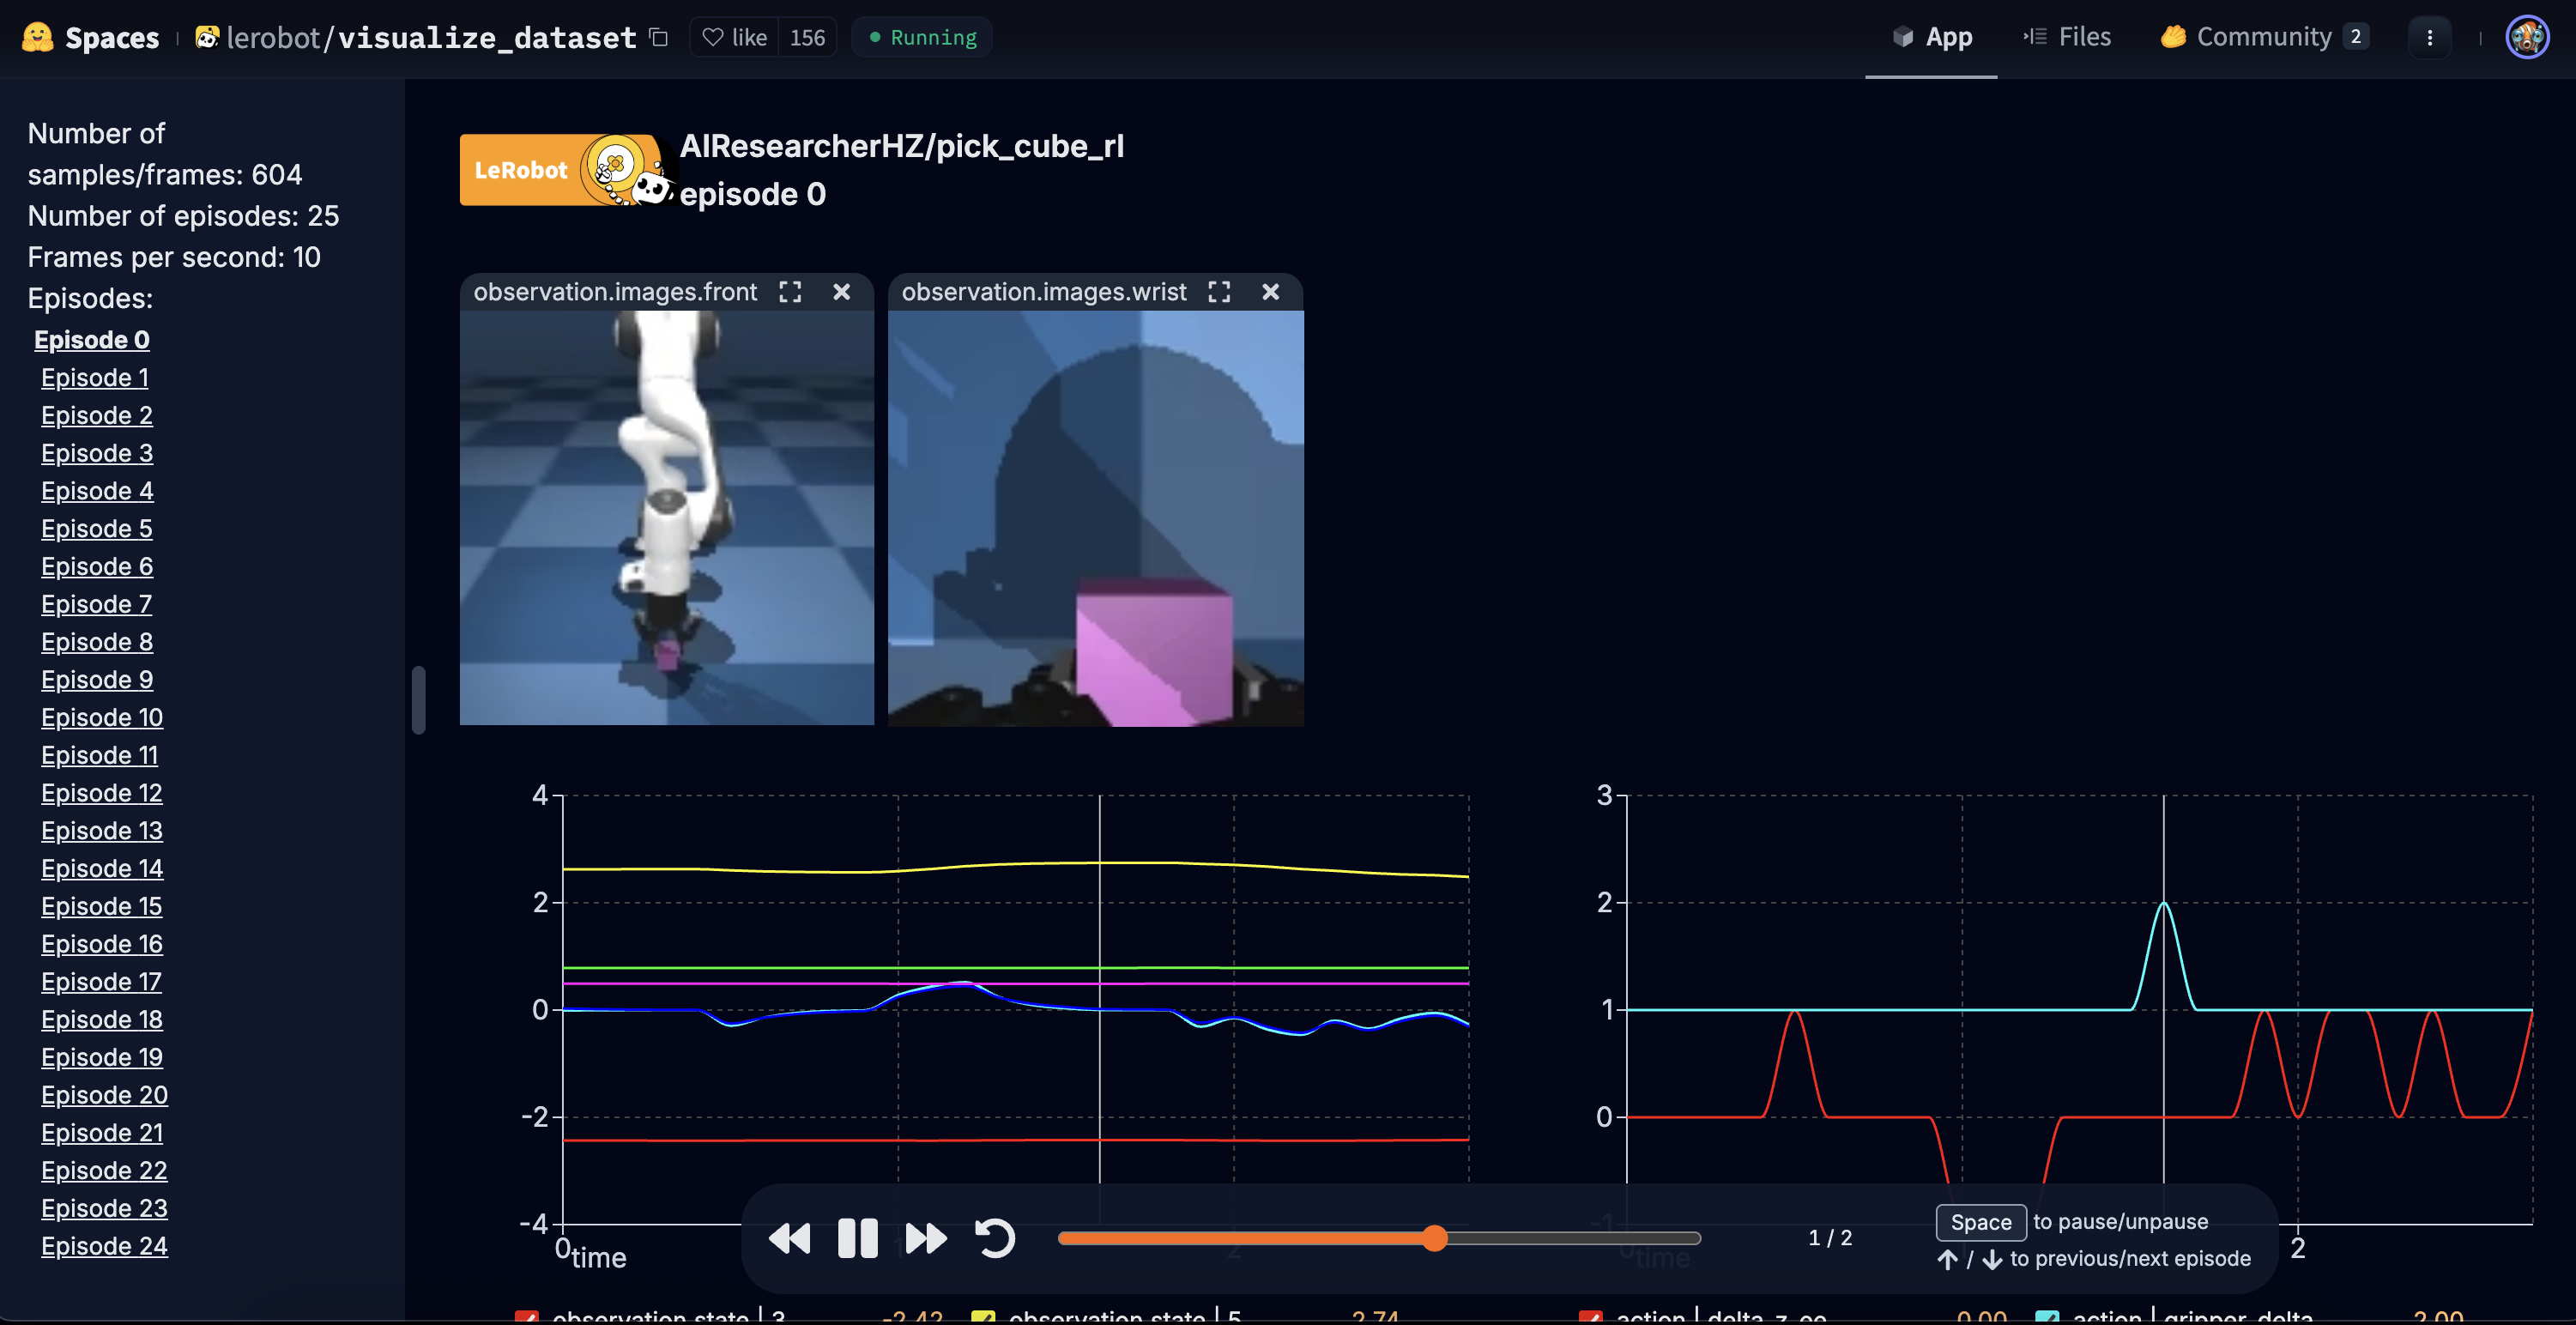

# Evaluation Setup

#### In order to utilize LeRobot tools for this purpose we must modify the setup. We updated lerobot/lerobot/scripts/rl/eval_policy.py

In [ ]:
# !/usr/bin/env python

# Copyright 2025 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import logging
import torch # Make sure torch is imported

from lerobot.common.cameras import opencv  # noqa: F401
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.factory import make_policy
from lerobot.common.robots import (  # noqa: F401
    RobotConfig,
    make_robot_from_config,
    so100_follower,
)
from lerobot.common.teleoperators import (
    gamepad,  # noqa: F401
    so101_leader,  # noqa: F401
)
from lerobot.configs import parser
from lerobot.configs.train import TrainRLServerPipelineConfig
from lerobot.scripts.rl.gym_manipulator import make_robot_env

logging.basicConfig(level=logging.INFO)

# MODIFIED: This function is adapted to evaluate a SmolVLA policy in a LeRobot environment.
def eval_policy(env, policy, n_episodes):
    sum_reward_episode = []
    task_prompt = "Pick up the cube."
    # Get the device the policy is on
    device = next(policy.parameters()).device

    for i in range(n_episodes):
        logging.info(f"--- Starting episode {i+1}/{n_episodes} ---")
        obs, _ = env.reset()
        episode_reward = 0.0
        policy.reset()
        while True:
            # Move all tensor values in the observation dict to the correct device
            for key, value in obs.items():
                if isinstance(value, torch.Tensor):
                    obs[key] = value.to(device)
            
            obs["task"] = task_prompt
            
            action = policy.select_action(obs)
            
            obs, reward, terminated, truncated, _ = env.step(action)
            
            obs.pop("task", None) 
            
            episode_reward += reward
            if terminated or truncated:
                logging.info(f"Episode finished with reward: {episode_reward}")
                break
        sum_reward_episode.append(episode_reward)

    success_rate = sum(r > 0 for r in sum_reward_episode) / len(sum_reward_episode)
    logging.info(f"Evaluation finished over {n_episodes} episodes.")
    logging.info(f"Episode rewards: {sum_reward_episode}")
    logging.info(f"Success rate (reward > 0): {success_rate:.2f}")

@parser.wrap()
def main(cfg: TrainRLServerPipelineConfig):
    env_cfg = cfg.env
    env = make_robot_env(env_cfg)
    dataset_cfg = cfg.dataset
    dataset = LeRobotDataset(repo_id=dataset_cfg.repo_id)
    dataset_meta = dataset.meta

    policy = make_policy(
        cfg=cfg.policy,
        # env_cfg=cfg.env,
        ds_meta=dataset_meta,
    )
    policy.from_pretrained(env_cfg.pretrained_policy_name_or_path)
    policy.eval()

    eval_policy(env, policy=policy, n_episodes=10)

if __name__ == "__main__":
    main()


#### In order to run LeRobot policy evaluation (action commands in Sim) - we must create a JSON config file

```bash
mkdir -p experiments/smolvla_eval
cd experiments/smolvla_eval
touch eval_config_smolvla.json
```

In [ ]:
//eval_config_smolvla.json
{
    "output_dir": null,
    "job_name": "smolvla_eval",
    "seed": 1000,
    "num_workers": 4,
    "batch_size": 256,
    "log_freq": 500,
    "dataset": {
        "repo_id": "AIResearcherHZ/pick_cube_rl" // update in future to use the processed dataset
    },
    "policy": {
        "type": "smolvla",
        "adapt_to_pi_aloha": false,
        "n_obs_steps": 1,
        "chunk_size": 16,
        "n_action_steps": 16,
        "device": "mps",
        "normalization_mapping": {
            "VISUAL": "MEAN_STD",
            "STATE": "MEAN_STD",
            "ACTION": "MEAN_STD"
        }
    },
    "env": {
        "type": "hil",
        "wrapper": {
            "gripper_penalty": 0,
            "display_cameras": true,
            "add_joint_velocity_to_observation": true,
            "add_ee_pose_to_observation": true,
            "crop_params_dict": {
                "observation.images.front": [0, 0, 128, 128],
                "observation.images.wrist": [0, 0, 128, 128]
            },
            "resize_size": [128, 128],
            "control_time_s": 15.0,
            "use_gripper": true,
            "fixed_reset_joint_positions": [0.0, 0.195, 0.0, -2.43, 0.0, 2.62, 0.785],
            "reset_time_s": 2.0,
            "control_mode": "gamepad"
        },
        "name": "franka_sim",
        "mode": "eval",
        "task": "PandaPickCubeGamepad-v0",
        "num_episodes": 50,
        "pretrained_policy_name_or_path": "lerobot/smolvla_panda_pick_cube", // change to fine-tuned model
        "device": "mps",
        "fps": 10
    }
}

# Model Fine-Tuning

This finetuning stage was done in Colab on an A100 and took approx 4 hours.

## Install conda
This cell uses `condacolab` to bootstrap a full Conda environment inside Google Colab.


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


## Install LeRobot
This cell clones the `lerobot` repository from Hugging Face, installs FFmpeg (version 7.1.1), and installs the package in editable mode.


In [ ]:
!git clone https://github.com/huggingface/lerobot.git
!conda install ffmpeg=7.1.1 -c conda-forge
!cd lerobot && pip install -e .

## Install SmolVLA dependencies

In [ ]:
!cd lerobot && pip install -e ".[smolvla]"

## Login into Hugging Face Hub

In [ ]:
!huggingface-cli login

## Start training SmolVLA with LeRobot

This cell runs the `train.py` script from the `lerobot` library to train a robot control policy.  

Make sure to adjust the following arguments to your setup:

`--dataset.repo_id=YOUR_HF_USERNAME/YOUR_DATASET`:  
   Replace this with the Hugging Face Hub repo ID where your dataset is stored

`--batch_size=64`: means the model processes 64 training samples in parallel before doing one gradient update. Reduce this number if you have a GPU with low memory.

`--output_dir=outputs/train/...`:  
   Directory where training logs and model checkpoints will be saved.

`--job_name=...`:  
   A name for this training job, used for logging and Weights & Biases.

`--policy.device=cuda`:  
   Use `cuda` if training on an NVIDIA GPU. Use `mps` for Apple Silicon, or `cpu` if no GPU is available.

`--wandb.enable=true`:  
   Enables Weights & Biases for visualizing training progress. You must be logged in via `wandb login` before running this.

In [ ]:
!cd lerobot && python lerobot/scripts/train.py \
  --policy.path=lerobot/smolvla_base \
  --dataset.repo_id=AIResearcherHZ/pick_cube_rl \
  --batch_size=64 \
  --steps=20000 \
  --output_dir=outputs/train/smolvla_panda_pick_cube \
  --job_name=smolvla_panda_pick_cube_training \
  --policy.device=cuda \
  --policy.repo_id=karimnihal/smolvla_panda_pick_cube \
  --wandb.enable=False

# Experimentation

Now with the setup complete and us having a fine-tuned model we can evaluate on the baseline model vs the finetuned version. We can simply update the ```eval_config_smolvla.json``` file to select which model to use for our experimenation. We can also change the number of episodes, starting positions, etc.

We evaluated on episodes/trials with the baseline model first:

```java
        "pretrained_policy_name_or_path": "lerobot/smolvla_panda_pick_cube",
```

We then evaluated on with the fine-tuned model:

```java
        "pretrained_policy_name_or_path": "karimnihal/smolvla_panda_pick_cube",
```


We run this command to run the sim and eval:

```bash
    mjpython lerobot/scripts/rl/eval_policy.py --config_path experiments/smolvla_eval/eval_config_smolvla.json
```